<a href="https://colab.research.google.com/github/akansalbe23-star/Predive_Analytics_using_Statistics/blob/main/Assignment_2/Predictive_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


In [ ]:
# Load dataset
df = pd.read_csv("/content/data.csv",encoding='ISO-8859-1')
df.head()

/tmp/ipython-input-3179334834.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv",encoding='ISO-8859-1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
# Extract NO2 concentration
x = df["no2"].dropna().values.astype("float32")
x = x.reshape(-1, 1)


In [ ]:
r = 102303808
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)
z = x + a_r * np.sin(b_r * x)


In [ ]:
scaler = StandardScaler()
z_norm = scaler.fit_transform(z)
z_tensor = torch.tensor(z_norm, dtype=torch.float32)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
G = Generator()
D = Discriminator()

optimizer_G = optim.Adam(G.parameters(), lr=1e-4)
optimizer_D = optim.Adam(D.parameters(), lr=1e-4)

batch_size = 128
epochs = 4000


In [ ]:
for epoch in range(epochs):

    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_z = z_tensor[idx]

    # ---------------------
    # Train Discriminator
    # ---------------------
    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)

    d_loss = -(
        torch.log(D(real_z) + 1e-8).mean() +
        torch.log(1 - D(fake_z.detach()) + 1e-8).mean()
    )

    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()
    # -----------------
    # Train Generator
    # -----------------
    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)

    g_loss = -torch.log(D(fake_z) + 1e-8).mean()

    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.3974 | G Loss: 0.7678
Epoch 500 | D Loss: 1.3612 | G Loss: 0.7120
Epoch 1000 | D Loss: 1.3815 | G Loss: 0.7125
Epoch 1500 | D Loss: 1.3888 | G Loss: 0.6950
Epoch 2000 | D Loss: 1.3798 | G Loss: 0.6896
Epoch 2500 | D Loss: 1.3726 | G Loss: 0.6861
Epoch 3000 | D Loss: 1.3791 | G Loss: 0.6888
Epoch 3500 | D Loss: 1.3947 | G Loss: 0.6915


In [ ]:
with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_fake_norm = G(noise).numpy()

z_fake = scaler.inverse_transform(z_fake_norm).flatten()


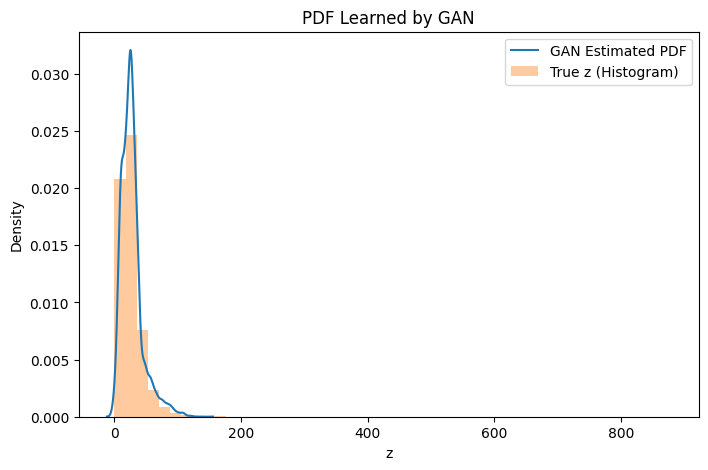

In [ ]:
kde = gaussian_kde(z_fake)

x_vals = np.linspace(z_fake.min(), z_fake.max(), 1000)

plt.figure(figsize=(8,5))
plt.plot(x_vals, kde(x_vals), label="GAN Estimated PDF")
plt.hist(z.flatten(), bins=50, density=True, alpha=0.4, label="True z (Histogram)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("PDF Learned by GAN")
plt.show()
